## INLÄMNING DEL 2

# Bearbeta data
- Läser in data från csv-fil
- Kontrollerar dataset
- Konverterar nödvändiga datatyper till rätt typ

In [1]:
import pandas as pd
from data_cleaner import load_data, DataCleaner

pd.options.display.float_format = "{:.2f}".format

# 1. Ladda & rensa
df_raw = load_data("data/health_study_dataset.csv")
df = DataCleaner(df_raw).process()



sex: clean
smoker: clean
Kolumnen 'disease' innehåller endast 0 och 1 - konverterad till bool.
Alla ID i 'id' är unika – inga dubbletter hittades.

column      dtype        unique values
--------------------------------------------------------------------------------
id           int64        800 uniques, min=1, max=800
age          int64        70 uniques, min=18, max=90
sex          category     ['F', 'M']
height       float64      351 uniques, min=144.4, max=200.4
weight       float64      424 uniques, min=33.7, max=114.4
systolic_bp  float64      385 uniques, min=106.8, max=185.9
cholesterol  float64      303 uniques, min=2.5, max=7.88
smoker       category     ['No', 'Yes']
disease      bool         [False, True]
--------------------------------------------------------------------------------


### Datakontroll och förbehandling

En kvalitetskontroll genomfördes av datasetet.  
- Kolumnerna `sex` och `smoker` har kontrollerats och konverterats till kategoriska variabler.
- Kolumnen `disease` bestod endast av värdena 0 och 1 och konverterades därför till en boolesk variabel.  
- Kontroll av `id` visade att samtliga observationer är unika, vilket innebär att inga dubbletter förekommer.  

Datasetet är därmed välstrukturerat och lämpligt för vidare analys.

# Beskrivande analys

,mean,median,std,min,max
age,49.43,50.00,14.50,18.00,90.00
height,171.85,171.35,9.80,144.40,200.40
weight,73.41,73.20,13.69,33.70,114.40
systolic_bp,149.18,149.40,12.79,106.80,185.90
cholesterol,4.93,4.97,0.85,2.50,7.88


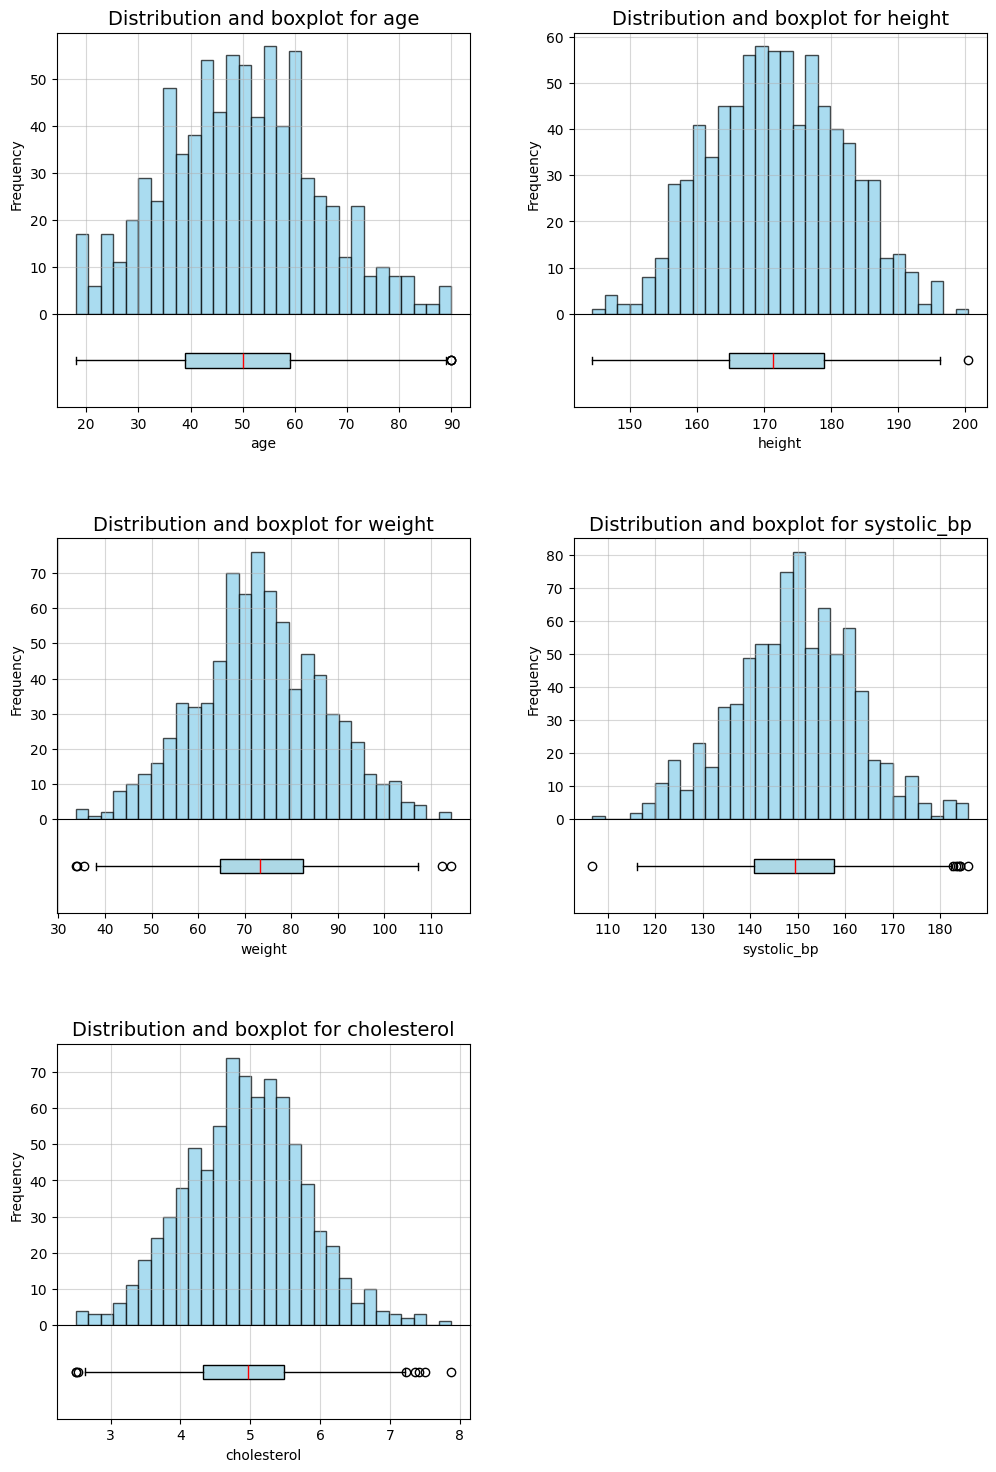

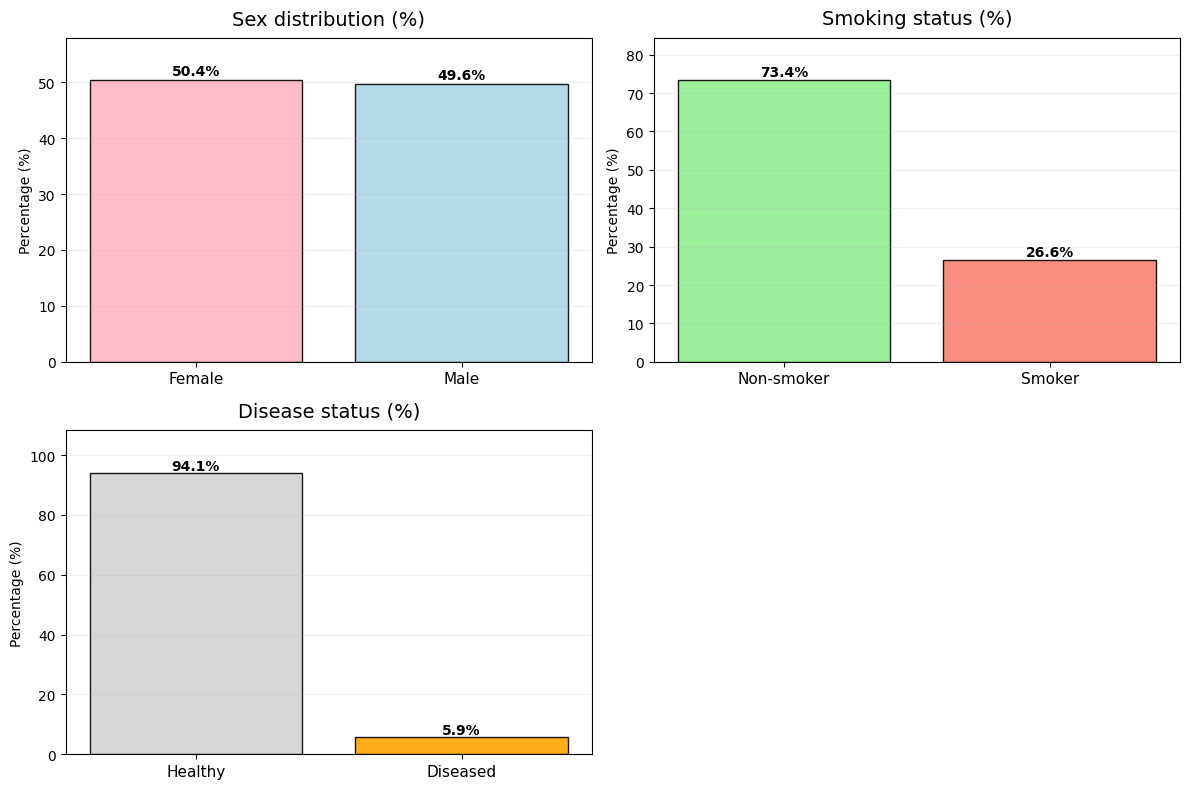

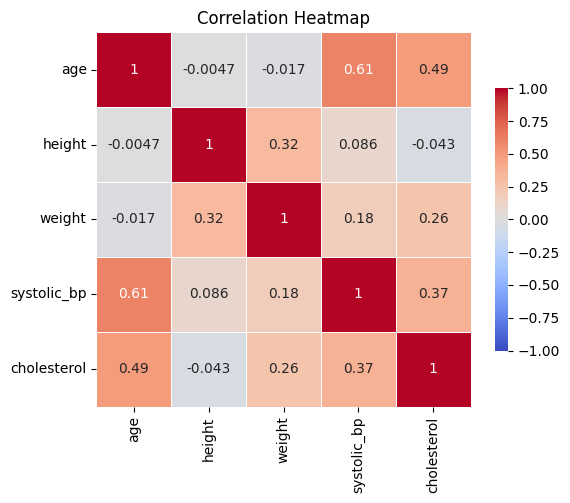

In [2]:
from visualization import summary_table, plot_all_num_distributions, plot_all_categorical_bars, plot_correlation_heatmap

# 1. Sammanfattningstabell
summary = summary_table(df)
display(summary)

# 2. Alla numeriska distributioner
plot_all_num_distributions(df)

# 3. Alla kategoriska fördelningar
plot_all_categorical_bars(df)

# 4. Korrelationsmatris
plot_correlation_heatmap(df)


## Tolkning av data

Den inledande analysen visar att datasetet innehåller **rimliga och medicinskt realistiska värden**, där de numeriska variablerna i huvudsak uppvisar **normalfördelade mönster**. Vissa extremvärden förekommer, särskilt i vikt, blodtryck och kolesterol, men dessa ligger inom tänkbara intervall och bedöms inte vara felregistreringar. Därför inkluderas samtliga observationer i den fortsatta analysen.

De kategoriska variablerna uppvisar däremot en tydlig **obalans i gruppstorlekar** för rökstatus och sjukdom. Andelen rökare är låg och endast en mindre del av deltagarna är sjuka. Denna skevhet innebär att gruppjämförelser här får lägre statistisk styrka och resultaten måste tolkas med försiktighet, särskilt för sjukdomsgruppen. Jämförelsen mellan könen är däremot välbalanserad och därmed mer tillförlitlig. 

Korrelationsanalysen ger en översiktlig bild av sambanden mellan de numeriska variablerna. Den tydligaste relationen är att **systoliskt blodtryck ökar med ålder**. Även **kolesterol** uppvisar en måttlig positiv korrelation med både **systoliskt blodtryck och ålder**, vilket antyder att dessa faktorer delvis samvarierar i populationen. Övriga samband är svaga och visar ingen tydlig linjär relation i datamaterialet.



# Simulering kopplad till caset

In [4]:
import numpy as np
from confidence_intervals import ci_prop_normal

# andel i verklig data
real_prop = (df["disease"] == True).mean()
n_data = len(df)

# CI för verklig andel
level = 0.95
ci_low, ci_high, sd, z = ci_prop_normal(real_prop, n_data, level=level)

# Simulering
rng = np.random.default_rng(42)
n_sim=1000
simulated = rng.random(n_sim) < real_prop #Create a list with True and False values similar to real_prop
#simulated = np.random.choice([True, False], size=1000, p=[real_prop, 1-real_prop]) # same but slower
sim_prop = simulated.mean()

print(f"Andel i data: {real_prop*100:.2f}%")
print(f"Andel i simulering: {sim_prop*100:.2f}%")
print(f"{int(level*100)}% CI (normalapprox) för verklig andel: [{ci_low*100:.2f}%, {ci_high*100:.2f}%]")
#print(f"z = {z:.3f}, SD = {sd*100:.2f}%")
print("Ligger simulerad andel inom bandet?",
      "Ja" if ci_low <= sim_prop <= ci_high else "Nej")

Andel i data: 5.88%
Andel i simulering: 6.50%
95% CI (normalapprox) för verklig andel: [4.25%, 7.50%]
Ligger simulerad andel inom bandet? Ja


### Tolkning av simulering:
 
Den simulerade andelen (6,30 %) ligger inom det 95-procentiga konfidensintervall som man kan förvänta sig kring den verkliga andelen (5,88 %). Eftersom simuleringen bygger på ett stort antal personer (1000 stycken) och sjukdomsförekomsten är låg, är det naturligt att andelen varierar något. Skillnaden är därför helt rimlig och beror på slumpen – simuleringen matchar datan väl.

# Systoliskt blodtryck

Vidare analyser görs för Systoliskt blodtryck då det kan antas vara utfallsvariabel, alltså andra värden kan antas vara en förklarande variabel för det systoliksa blodtrycket.

In [ ]:
from health_analyzer import HealthAnalyzer

analyzer = HealthAnalyzer(df, bp_col="systolic_bp")

# Histogram och boxplot i grid för kategoriska kolumner
fig, axes = analyzer.plot_bp_hist_box_grid(
    group_cols=["sex", "smoker", "disease"],
    bins=30
)
plt.show()

# Sammanfattningstabell för kategoriska kolumner
bp_cat_summary = analyzer.bp_summary_all_categorical()
display(bp_cat_summary.T)


# Spridningsdiagram för numeriska kolumner
analyzer.plot_bp_scatter_grid(
    x_cols=["age", "weight", "height", "cholesterol"]
)
plt.show()

# Korrelationstabell för numeriska kolumner
cols = ["systolic_bp", "age", "weight", "height", "cholesterol"]
corr = analyzer.df[cols].corr()
corr_row = (
    corr.loc["systolic_bp"]          # hämta raden
        .drop("systolic_bp")         # ta bort 1.00
        .sort_values(ascending=False) # sortera
        .to_frame(name="Correlation with systolic_bp")
)
display(corr_row.T)

### Tolkning: 

**Skillnaderna i systoliskt blodtryck mellan de kategoriska grupperna är genomgående små**.
Män har något högre blodtryck än kvinnor, men skillnaden är liten. Rökare och icke-rökare uppvisar nästan identiska värden. Personer med sjukdom har något högre blodtryck, men gruppen är mycket liten, vilket gör resultatet osäkert. Histogrammen indikerade ungefär normalfördelade data, vid användning av normalapproximation för att beräkna konfidensintervallen. Dessa intervall överlappar tydligt för samtliga grupper, vilket ytterligare stödjer slutsatsen att skillnaderna mellan grupperna är små.. 

I korrelationsanalysen ses ett tydligt **samband** mellan systoliskt blodtryck och **ålder** (r = 0.61), vilket innebär att blodtrycket ökar med stigande ålder. Ett svagare samband finns mellan blodtryck och **kolesterol** (r = 0.37). Vikt och längd visar däremot mycket svaga samband (r < 0.20), vilket antyder att dessa variabler inte är starka förklaringsfaktorer för blodtryck i denna population.

## Konfidensintervall

In [ ]:
from confidence_intervals import ci_methods_table 

# CI för systoliskt blodtryck med tre metoder

ci_df = ci_methods_table(df["systolic_bp"], confidence=0.95, n_boot=10_000, random_state=42)
display(ci_df.style.format({"Medel": "{:.2f}", "KI nedre": "{:.2f}", "KI övre": "{:.2f}"}))


### Tolkning av skattning av konfidensintervall
Resultaten från de tre metoderna visar liknande 95 %-konfidensintervall för medelvärdet av systoliskt blodtryck, vilket tyder på en **stabil skattning som inte är känslig för metodval**.

Normalapproximationen fungerar väl då urvalet är stort och blodtrycket är ungefär normalfördelat (se figur "Distribution of systolic blood pressure" ).

Bootstrapmetoderna ger en icke-parametrisk kontroll, där BCa justerar för eventuell skevhet. De överlappande intervallen antyder att skillnaderna främst beror på slumpvariation.

## Test hur bra CI-metoderna för konfidensintervall är

Med hjälp av simulering undersöks om olika konfidensintervallmetoder verkligen når sin avsedda täckningsgrad och hur breda intervallen blir. Det ger en praktisk kontroll av metodernas noggrannhet.

In [ ]:
from ci_simulation import evaluate_ci_methods

res = evaluate_ci_methods(df["systolic_bp"],
                            n=50, trials=100, confidence=0.95, n_boot=20_000, random_state=42)

res_sv = (
    res.reset_index()
       .rename(columns={
           "method": "Metod",
           "coverage": "Täckningsgrad",
           "avg_width": "Genomsnittlig bredd",
           "std_width": "SD för bredd"
       })
       .round(3)
)

display(
    res_sv.style.format({
        "Täckningsgrad": "{:.2f}",
        "Genomsnittlig bredd": "{:.3f}",
        "SD för bredd": "{:.3f}"
    }).set_caption("Jämförelse av konfidensintervall-metoder för systoliskt blodtryck"))


### Tolkning av test av olika metoder för skattning av konfidensintervall

Resultaten visar att alla tre metoder – normalapproximation, bootstrap (percentil) och bootstrap BCa – fungerar väl för att skatta 95 % konfidensintervall för medelvärdet av systoliskt blodtryck.

-   **Täckningsgraden** ligger på 0,95–0,97, vilket ligger mycket nära den teoretiska nivån 0,95.

-   **Intervallbredderna** är nästan identiska (≈ 7,0), med mycket liten variation mellan metoderna.

-   **Bootstrap-metoderna**, särskilt BCa, brukar ge fördelar vid skeva fördelningar eller små stickprov, men här syns ingen tydlig skillnad eftersom blodtrycket är ungefär symmetriskt och stickproven (n=50) är tillräckligt stora för att normalapproximationen ska fungera bra.


## Hypotesprövning

Hypotes: Rökare har högre medel-blodtryck än icke-rökare

H₀: mean(Yes) − mean(No) = 0

H₁: mean(Yes) − mean(No) > 0 (rökare har högre medelblodtryck)

## Tillämpning och visualisering av hypotesprövning

In [ ]:
from hypothesis_analyzer import MeanDiffAnalyzer

smoker_yes = df.loc[df["smoker"] == "Yes", "systolic_bp"]
smoker_no  = df.loc[df["smoker"] == "No",  "systolic_bp"]

print(f"Antal rökare: {len(smoker_yes)}")
print(f"Antal icke-rökare: {len(smoker_no)}")

analyzer = MeanDiffAnalyzer(
    smoker_yes,
    smoker_no,
    name1="Rökare",
    name2="Icke-rökare",
    confidence=0.95,
    two_sided=False,
    n_boot=10_000,
)

# Resultattabell
res_df = analyzer.summary_table()
display(
    res_df.style
        .format({
            "Observerad skillnad": "{:.3f}",
            "p-värde": "{:.3f}",
            "KI nedre": "{:.3f}",
            "KI övre": "{:.3f}",
        })
        .set_caption(
            "Jämförelse mellan bootstrap och Welch’s t-test\n(systoliskt blodtryck, rökare vs icke-rökare)"
        )
)

# Stor figur med tre paneler
fig, axes = analyzer.plot_overview()

### Tolkning

Både bootstrapmetoden och Welch’s t-test ger mycket liknande resultat för skillnaden i medelvärde av systoliskt blodtryck mellan rökare och icke-rökare.
Den observerade skillnaden är liten (≈ 0,47 mmHg), och båda metoderna ger konfidensintervall som inkluderar noll. Detta innebär att ingen statistiskt säkerställd skillnad påvisas vid 95 % konfidensnivå.

De tre graferna visar fördelningar som är centrerade nära noll, vilket stämmer överens med att den observerade skillnaden är liten. Symmetrin i t- och normalfördelningen följer av antagandena i metoderna, medan bootstrapfördelningen visar att resultaten är stabila även utan sådana antaganden.

P-värdena (0,50 för bootstrap och 0,33 för Welch’s t-test) ligger långt över den vedertagna signifikansgränsen på 0,05. Nollhypotesen kan därför inte förkastas, vilket innebär att resultaten inte tyder på någon verklig skillnad i systoliskt blodtryck mellan rökare och icke-rökare.

Sammantaget visar både bootstrapmetoden och Welch’s t-test att eventuella skillnader i systoliskt blodtryck mellan rökare och icke-rökare sannolikt beror på slumpmässig variation snarare än en verklig effekt.

## Kontrollera hur säkert hypotestestet är, hittar en skillnad när den finns (power)

In [ ]:
from power_analyzer import PowerAnalyzer

smoker_yes = df.loc[df["smoker"] == "Yes", "systolic_bp"]
smoker_no  = df.loc[df["smoker"] == "No",  "systolic_bp"]

power_an = PowerAnalyzer(
    smoker_yes,
    smoker_no,
    name1="Rökare",
    name2="Icke-rökare",
    alpha=0.05,
    target_power=0.80,
    trials_effect=800,
    trials_n=800,
    one_sided=True,
)

# 1) Power för nuvarande studie
print(
    f"Power för verkliga stickprovet (N = {power_an.real_total_n}, "
    f"Δ_obs = {power_an.obs_diff:.2f}): {power_an.real_power():.3f}"
)

# 2) Kurva: power vs effektstorlek + text-sammanfattning
msg_effect = power_an.plot_power_by_effect()
print(msg_effect)

# 3) Kurva: power vs total N + text-sammanfattning
msg_n = power_an.plot_power_by_n()
print(msg_n)

# 4) Analytiska beräkningar i tabellform
analytic_df = power_an.analytic_requirements()

def highlight_calculated_cells(df):
    """Gör texten fet och orange för beräknade celler."""
    styles = pd.DataFrame("", index=df.index, columns=df.columns)

    highlight_style = (
        "font-weight: bold; "
        "color: #ff7f0e;"   # orange färg
    )

    for idx, row in df.iterrows():
        if row["Typ"] == "Effekt givet N":
            styles.loc[idx, "Delta"] = highlight_style
        elif row["Typ"] == "N givet effekt":
            styles.loc[idx, "N_totalt"] = highlight_style

    return styles
    
display(
    analytic_df.style
        .format({"Delta": "{:.2f}", "Relativ storlek": "{:.2f}", "N_totalt": "{:.0f}"})
        .apply(highlight_calculated_cells, axis=None)
    )

### Tolkning
Den observerade skillnaden i systoliskt blodtryck mellan rökare och icke-rökare var mycket liten (≈ 0,47 mmHg) och poweranalysen visar att den här studien har låg power (≈ 20 %). Det betyder att sannolikheten att upptäcka en så liten effekt med N = 800 är låg.

Både simuleringarna och de analytiska powerberäkningarna visar att:
-   en betydligt större sann effekt (≈ 2–2,5 mmHg) hade krävts för att nå 80 % power med nuvarande stickprovsstorlek, och
-   om den verkliga skillnaden faktiskt är 0,47 mmHg skulle ett mycket stort stickprov (≈ 23 000 individer totalt) behövas för att nå 80 % power.

Detta innebär att studien är underpowered, vilket gör att den icke-signifikanta skillnaden inte kan tolkas som stöd för att ingen verklig effekt finns. Resultaten bör därför tolkas försiktigt, och studien kan inte ge starka slutsatser om skillnader i blodtryck mellan rökare och icke-rökare.


## Modellering
Syftet är att undersöka hur systoliskt blodtryck påverkas av andra variabler genom:

1. **Enkel linjär regression**  
   – analyserar sambandet mellan blodtryck och varje variabel separat.

2. **Multipel linjär regression**  
   – inkluderar de variabler som visat starkast samband i steg 1, för att utvärdera deras gemensamma effekt.

3. **OLS-regression (full och reducerad modell)**  
   – används för att identifiera vilka variabler som är statistiskt signifikanta och ger bäst modell.


In [ ]:
from analysis2 import regression_panel, simple_regressions, multiple_regression_panel_full, ols_full, compare_models

variables_all = ["age", "cholesterol", "weight", "height"]


print(f"\n{'='*60}")
print("1. Enkel regression för varje variabel")
print(f"{'='*60}\n")
summary_df, models = simple_regressions(df, variables_all)
display(summary_df)


for var in ["age", "cholesterol"]: 
    regression_panel(df, var, model=models[var])


print(f"\n{'='*60}")
print("2. Multipel linjär regression för de två variabler med störst korrelation")
print(f"{'='*60}\n")

multiple_regression_panel_full(df, ['age','cholesterol'])


print(f"\n{'='*60}")
print("3a. OLS-regression — full modell (alla variabler)")
print(f"{'='*60}\n")

model_full = ols_full(df, variables_all)
print("\nFull modell (alla variabler)")
print(f"R²      : {model_full.rsquared:.3f}")
print(f"Adj R²  : {model_full.rsquared_adj:.3f}")
print(model_full.summary2().tables[1][["Coef.","P>|t|"]])


print(f"\n{'='*60}")
print("3b. OLS-regression — reducerad modell (age + weight)")
print(f"{'='*60}\n")

model_reduced = ols_full(df, ["age","weight"])
print("\nReducerad modell (age + weight)")
print(f"R²      : {model_reduced.rsquared:.3f}")
print(f"Adj R²  : {model_reduced.rsquared_adj:.3f}")
print(model_reduced.summary2().tables[1][["Coef.","P>|t|"]])

multiple_regression_panel_full(df, ['age', 'weight'])



model_two = ols_full(df, ["age","cholesterol"])

summary_models = compare_models(summary_df=summary_df, model_two=model_two, model_full=model_full, model_reduced=model_reduced)
display(summary_models)


### Tolkning av regressionsanalysen. 

#### 1. Enkel regressionsanalys
Här analyserades varje variabels samband med systoliskt blodtryck i separata enkelmodeller.

I enkel linjär regression gäller att r² = R², vilket innebär att determinationskoefficienten (R²) direkt kan härledas från korrelationsvärdet. **Ålder visade starkast samband med ett R² på 0.37**, vilket innebär att ungefär **37 % av variationen i blodtryck kan förklaras av ålder**. Kolesterol hade ett svagare samband (R² = 0.14), medan vikt och längd nästan inte bidrog till att förklara variationen i blodtryck.

Residualplots för både ålder och kolesterol visade en relativt symmetrisk spridning kring nollinjen, vilket indikerar avsaknad av tydliga systematiska fel i modellerna. Histogrammen var grovt normalfördelade, men **Q–Q-plotterna avvek tydligt från 45°-linjen, särskilt i ytterområdena**, vilket tyder på att residualerna inte är perfekt normalfördelade och att variationen i datan är större än vad modellen förutsätter.


#### 2. Multipel regressionsanalys (ålder + kolesterol)

Här kombinerades de två variabler som visade starkast samband med blodktryck i den enkla regressionsanalysen. Syftet var att undersöka om modellen förbättras när båda variablerna används samtidigt istället för var och en för sig.

Resultaten visade att modellen ökade något i förklaringsgrad, men inte avsevärt. R² steg endast marginellt jämfört med ålder ensam, vilket indikerar att **kolesterol endast tillför en begränsad mängd ny information utöver ålder**. I residualplottarna låg punkterna fortfarande spridda men symmetriskt runt nollinjen, vilket antyder att modellen inte lider av systematiska fel. Samtidigt syns även här avvikelser i Q–Q-plotten, vilket antyder att residualerna inte är helt normalfördelade.

Sammanfattningsvis förbättrar kombinationen ålder + kolesterol modellen något, men ålder är fortfarande den dominerande prediktorn.


#### 3. OLS-modell med fyra variabler (full modell)
En OLS-regression med alla fyra variabler (ålder, vikt, kolesterol och längd) genomfördes för att utvärdera om en mer komplex modell förbättrar förklaringsgraden. Den fulla modellen gav ett R² på 0.407 och ett justerat R² på 0.404, vilket endast är en liten ökning jämfört med modellen med enbart ålder + kolesterol.

Av de fyra variablerna var **endast ålder och vikt statistiskt signifikanta (p<0,05)**, medan kolesterol och height saknade signifikant effekt (p>0,05). Det innebär att de två sistnämnda inte bidrar med nämnvärd extra förklaringskraft när de andra variablerna redan ingår i modellen.

Trots fler prediktorer ökade modellens förklaringsgrad alltså inte nämnvärt — vilket tyder på redundans och viss överlappning i variablernas informationsinnehåll.

#### 4. Reducerad modell (ålder + vikt)
Då en förenklad modell ofta är mer värdefull i praktiken testades en reducerad modell bestående av ålder och vikt. Resultatet gav ett R² på 0.405 och ett justerat R² på 0.404, vilket är praktiskt taget identiskt med fulla modellen trots att två variabler uteslöts.

Detta innebär att **ålder och vikt ensamma förklarar nästan lika mycket variation i blodtryck som modellen med alla fyra variabler**, vilket gör den reducerade modellen mer effektiv och lättare att tolka — utan förlust av förklaringsstyrka.

#### SLUTSATS
De mest informativa variablerna för att förklara systoliskt blodtryck är **ålder och vikt**.
Kolesterol och längd bidrar inte med väsentlig ny information i närvaro av dessa variabler.
Den reducerade modellen är därför att föredra framför den fulla — enkel, tydlig och nästan lika stark.


In [ ]:
from PCA import run_pca

pca_vars = ["age", "weight", "height", "cholesterol"]

pca_df, loadings, explained, pca_model = run_pca(df, pca_vars)



### PCA – tolkning

PCA reducerade de fyra variablerna till två huvudkomponenter som tillsammans förklarar **71,3 %** av variationen, vilket betyder att en stor del av informationen i datasetet kan sammanfattas i två dimensioner.

-   **PC1 (38,96 %) domineras av ålder och kolesterol**, vilket innebär att individer med höga värden på dessa hamnar högre åt höger i plottens x-led.

-   **PC2 (32,36 %) förklaras främst av vikt och längd**, vilket separerar individer i y-led.

I PCA-scatterplotten syns en tydlig färggradient längs PC1-axeln, vilket innebär att högre blodtryck främst förekommer hos individer med högre PC1-värden. Eftersom PC1 domineras av ålder och kolesterol tyder detta på att variation i blodtryck i första hand samvarierar med dessa variabler — sett ur ett strukturellt perspektiv, inte som en prediktionsmodell.

## METODVAL
### Deskriptiv statistik och visualiseringar

Histogram, boxplots och sammanfattande mått (medelvärde, median, standardavvikelse) användes för att beskriva variablernas fördelning. Detta är standardmetoder för att identifiera centraltendens, spridning och möjliga extremvärden.

Källor: Pandas descriptive statistics och Matplotlib histogram/boxplot.


### Simulering kopplad till caset

 Ett 95 % konfidensintervall beräknades för andelen personer med sjukdom med normalapproximation, vilket är en vanlig metod när stickprovet är stort. För att kontrollera rimligheten i resultatet simulerade jag ett nytt stickprov med samma sannolika andel och jämförde den simulerade andelen med intervallet. Syftet var att se om variationen kan förklaras av slumpen.

Källor: NumPy-dokumentation; Agresti (2018), Statistical Methods for the Social Sciences.

### Konfidensintervall (normalapproximation, bootstrap och BCa)

För att skatta konfidensintervallet för medelvärdet av systoliskt blodtryck användes tre metoder:
-   Normalapproximation – lämplig vid stora stickprov då medelvärdet närmar sig normalfördelning enligt centrala gränsvärdessatsen.
-   Bootstrap percentil – en icke-parametrisk metod som inte kräver normalitet och baseras på resampling av datan.
-   Bootstrap BCa – en förbättrad bootstrapvariant som korrigerar för bias och skevhet och kan ge mer tillförlitliga intervall vid snedfördelade data.

Samtliga metoder gav nästan identiska konfidensintervall, vilket visar att skattningen är robust. Normalapproximationen bedöms därför fungera väl i detta fall, samtidigt som bootstrapmetoderna ger en viktig kontroll utan parameterrisker.

Källor
-   Wasserman, L. (2004). All of Statistics. Springer.
-   Efron, B., & Tibshirani, R. J. (1993). An Introduction to the Bootstrap. Chapman & Hall/CRC.

### Hypotesprövning
För att testa om rökare har högre systoliskt blodtryck än icke-rökare användes två metoder:
1. Welch’s t-test
Welch-testet valdes eftersom grupperna har olika storlek och kan ha olika varians, vilket gör det mer robust än det klassiska t-testet vid heterogen spridning. Testet kräver inte antagandet om lika varians och anses vara standard vid jämförelse av två oberoende grupper med okända och olika variansparametrar (Welch, 1947).

2. Bootstrap-test av medelskillnaden
Som komplement användes ett icke-parametriskt bootstrap-test baserat på resampling av gruppernas data. Metoden kräver inte normalfördelning och ger en direkt empirisk uppskattning av p-värde och konfidensintervall (Efron & Tibshirani, 1993).

Kombinationen av Welch’s t-test och bootstrap ger en robust prövning av hypotesen och möjliggör kontroll av resultaten även om normalantagandet inte skulle hålla.

Källor
-   Welch, B. L. (1947). The generalization of “Student’s” problem…
-   Efron, B., & Tibshirani, R. J. (1993). An Introduction to the Bootstrap.

### Poweranalys
För att bedöma studiens statistiska styrka genomfördes både simulerad och analytisk poweranalys:
-   Simulerad power för det faktiska stickprovet:
Power uppskattades med resampling baserat på de observerade blodtrycksvärdena för rökare och icke-rökare. I varje simulering drogs nya urval inom respektive grupp, en effektskillnad Δ lades till gruppen rökare och ett Welch’s t-test (ensidigt, α = 0,05) beräknades. Andelen simuleringar med p < 0,05 användes som skattning av power för det faktiska N (= 800) och den observerade effekten (Δ ≈ 0,47 mmHg). Denna typ av resampling-baserad poweranalys rekommenderas när man vill bevara den verkliga datans spridning och obalans mellan grupper.
-   Simulerad power som funktion av effektstorlek och stickprovsstorlek:
Samma metod användes för att simulera power vid olika effektskillnader (Δ) med nuvarande N, samt vid olika totala stickprovsstorlekar med bibehållen gruppfördelning. Detta gav en bild av hur power förändras om effekten vore större eller studien vore större.

-   Analytiska beräkningar (normalapproximation):
Med antagande om normalfördelning användes standardformler för skillnad i två medelvärden för att beräkna ungefär
    (i) hur stor effekt som skulle krävas för 80 % power givet nuvarande N, samt
    (ii) hur stort N som skulle krävas för 80 % power givet den observerade effekten.

Dessa beräkningar fungerar som ett teoretiskt komplement till simuleringen.

Källor: 
-   Good, P. (2006). Resampling Methods: A Practical Guide to Data Analysis.
-   Wasserman, L. (2004). All of Statistics.
-   Efron, B., & Tibshirani, R. (1993). An Introduction to the Bootstrap.

### Modellering
För att undersöka hur systoliskt blodtryck påverkas av andra variabler byggdes successivt regressionsmodeller med ökande komplexitet:

Enkel linjär regression
– analyserade varje variabels samband med blodtryck separat, med R² som mått på förklaringsgrad.

Multipel linjär regression
– inkluderade variabler med högst samband för att studera deras gemensamma förklaringsvärde och eventuell överlappning i prediktion.

OLS-modell (full och reducerad)
– den fulla modellen utvärderade samtliga variabler samtidigt, medan en reducerad modell byggdes baserat på vilka faktorer som var statistiskt signifikanta (p < 0.05) och gav bäst balans mellan enkelhet och förklaringsstyrka.

Syftet med denna sekventiella modellering var att identifiera den minsta modell som på ett robust sätt förklarar variationen i blodtryck.

Källor: 
-   Montgomery et al. (2021). Introduction to Linear Regression.


### Principalkomponentanalys (PCA)

För att reducera dimensionalitet och identifiera mönster i de numeriska variablerna genomfördes en PCA på age, weight, height och cholesterol. Samtliga variabler standardiserades med z-skalning innan analysen, då PCA är känsligt för skillnader i skalnivå. Därefter extraherades två huvudkomponenter och visualiserades i ett tvådimensionellt plan, färgkodade efter systoliskt
blodtryck. Syftet med PCA var att undersöka hur variablerna samvarierar och om det finns övergripande strukturer i datan, utan att skapa en prediktionsmodell.

Källor:
-   Jolliffe, I. & Cadima, J. (2016). Principal Component Analysis: A Review.
